TO DO
***

**TO DO:**

Include an introduction to your notebook, setting the context and
describing what the reader can expect as they read down through
the notebook.


**

google pep 8 style code for python

**

**CLEAN UP**

`It tries to learn a smaller representation of its input (encoder) and then reconstruct its input from that smaller representation (decoder). An anomaly score is designed to correspond to the reconstruction error.`

Nice article here: https://thingsolver.com/time-series-anomaly-detection-using-a-variational-autoencoder-vae/#:~:text=It%20tries%20to%20learn%20a,)%2C%20a%20Bayesian%20neural%20network.

**Project Task:**

- On the keras5 website, there is an example of time-series anomaly detection  


- Re-create this example in a notebook of your own, explaining the concepts


- clearly explain each keras function used, referring to the documentation.


***
DELETE TO DO AFTERWARDS. JUST SOME GUIDENCE NOW. 
***



<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTy_W0CYhBKCrSlAkabQWffjRke71B63ixOUA&usqp=CAU" alt="anomaly" style="width: 380px;" align=right/>


<h1 style="color: #001a79;">Anomaly Detection using Keras</h1>

<hr style="border-top: 1px solid #001a79;" />

Offical documentation: https://keras.io/examples/timeseries/timeseries_anomaly_detection/

<h2 style="color: #001a79;">Introduction</h2>

<hr style="border-top: 1px solid #001a79;" />


This notebook is a re-creation of the timeseries anomaly detection using an Autoencoder.


The goal of this notebook is to display how we can reconstruct convilutional autoencoder model to detect anomalies using a timeseries. In other words, I will use keras on top of tensorflow to build and train a model which will hopefully detect anomolies.


The following code was adapted from the official documentation cited above and also from my lectures notebook which can be found here: https://github.com/ianmcloughlin/2223-S1-machine-learn-stats/blob/main/notebooks/05-evaluation.ipynb



<h2 style="color: #001a79;">Importing Modules</h2>

<hr style="border-top: 1px solid #001a79;" />

In [1]:
# For numerical arrrays.
import numpy as np

# Dealing with dataframes. 
import pandas as pd

# For neural networks.
import tensorflow.keras as keras

# For data visualisation. 
from matplotlib import pyplot as plt

<h3 style="color: #001a79;">TensorFlow</h3>


Tensorflow is a platform widely using in machine learning and statistics. It purpose is to aid with data automation, model tracking, performance monitoring and model retraining. 

Offical documentation can be found here: https://www.tensorflow.org/learn

<h3 style="color: #001a79;">Keras</h3>


Keras is a deep learning API which runs on top of TensorFlow. It's purpose is to provide a simple and flexible way of experimenting with ideas and producing fast results. It is an important library for completeing research. 


Offical documentation can be accessed here: https://keras.io/


<h2 style="color: #001a79;">Loading the data</h2>

<hr style="border-top: 1px solid #001a79;" />

https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

For this experiment the Numenta Anomaly Benchmark(NAB) dataset is used which can be found [here](https://www.kaggle.com/datasets/boltzmannbrain/nab). This an open source dataset is an artifical timeseries where the data is ordered, timestamped and has single-valued metrics. It is open source and contains labelled real-world time-series data which is what makes it so simple and effective to use. 

There are two csv files associated with this dataset which we will use for training and testing of data. The next code cell sets these up with their variable names. 

`artificialNoAnomaly/art_daily_small_noise.csv` contains a timestamp and some values. This csv contains articival data which doesn't contain any anomalies. This dataset will be used for training the model. 

`artificialWithAnomaly/art_daily_jumpsup.csv`also contains timestamps and values. The difference is that this file contains anomalies. This will be used for testing the model. 


In [2]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly for training.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly for testing
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

You can have a look at the urls in our web-browser. Follow the http links provided fromthe following two cells. Here you will see the raw data for these CSVs.

In [3]:
# http for data file without anomaly for training.
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
# http for data file with anomaly for testing. 
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

<h3 style="color: #001a79;">Timeseries data without anomalies</h3>


Let's take a look at the data without anomalies using pandas to read in the csv file. 

In [5]:
# Small noise dataframe (no anomaly) for training.
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

Pandas has a lot of functionality when dealing with dataframes. I will use some of these functions to have a look at the data and ensure everything is in order. 

Offical documentation can be found here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

In [6]:
# describe returns descriptive analysis of df. 
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [7]:
# head returns the first 5 rows of a df. 
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [8]:
# iloc returns data at idex specified. 
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

This is interesting development. Here, iloc has shown us the first row of data. What's curious is that the value appears to have been rounded. If you took a look at the raw data in the http earlier you would have seen the first value is differs from the value produced in the previous cell. 

Have a look at a screen-snip of it

![smallnoise](images/small_noise.jpg)

<br>

The first value is 18.324918539200002 whereas my dataframe has it as 18.324919

Let's look at row one using different methods:

In [9]:
# Let's look at row 1 value.
df_small_noise.iloc[0]['value']

18.3249185392

In [10]:
# Let's look at row 1 value 1.
df_small_noise.iloc[0].values[0]

18.3249185392

In [11]:
# Gives the closest value but still rounded
df_small_noise.iloc[0].values[0] * 10e12

183249185392000.0

After a bit of digging I foung a blogpost on stackoverflow which can be found here: https://stackoverflow.com/questions/43227058/why-is-python-pandas-dataframe-rounding-my-values


Someone else ran into similar issues and one response suggested it is the percision setting of pandas. When I researched the pandas documentation I found my answer here: https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html#frequently-used-options


It suggests that pandas is not changing the actual value but the way in which the value is displayed to us. Therefore, I have conclused that this is just a simple display issue which will not affect results when processing the data. 

<h4 style="color: #001a79;">Plotting timeseries data without anomalies</h4>

Let's take a look at our dataframe without anomalies from the small noise csv. 

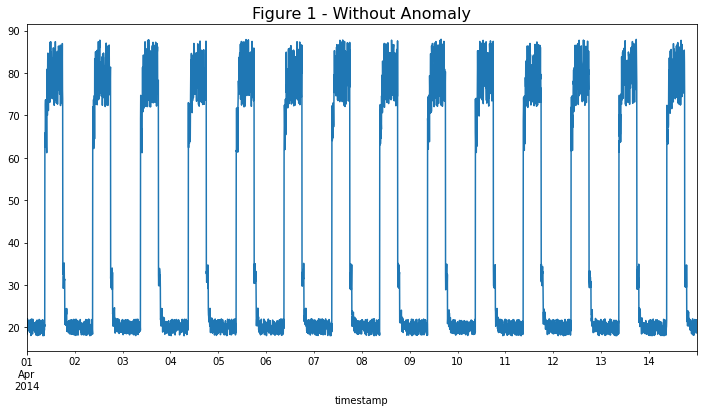

In [26]:
# Plot without anomalies. 
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Figure 1 - Without Anomaly", size=16)

# ax=ax means it will create its own seet of axes . 
df_small_noise.plot(legend=False, ax=ax);

The data in Figure 1 will be used for training the model. 

<h3 style="color: #001a79;">Timeseries data with anomalies</h3>


Let's take a look at the data with anomalies using pandas to read in the csv file. 

In [13]:
# jumpsup dataframe (eith anomaly) for testing.
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [15]:
# describe returns descriptive analysis.
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [14]:
# Returns first 5 rows. 
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [16]:
# iloc returns specific row
df_daily_jumpsup.iloc[0]['value']

19.761251903

We can see the same thing has happened with the displaying of data. The value of the first row is different to the raw value. However, it is only afftected when displaying data using pandas. 


![jumpsup](images/jumpsup.jpg)

In [17]:
# shape returns the dimensionality of df. 
df_daily_jumpsup.shape

(4032, 1)

<h4 style="color: #001a79;">Plotting timeseries data with anomalies</h4>

Let's plot the dataframe with anomaly data from the jumpsup csv. 

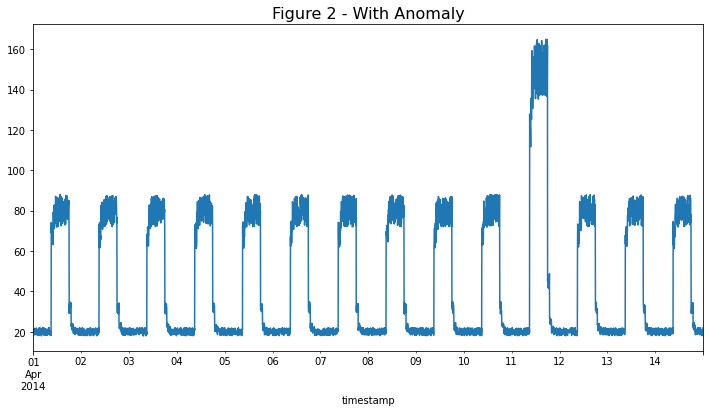

In [27]:
# Plot with anomalies. 
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Figure 2 - With Anomaly", size=16)

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

We can see here in Figure two that there is a jump in the data and the range of the y-axis differes from Figure 1 suggesting an anomaly is present. This data will be used for testing the model. 

<br>

<h2 style="color: #001a79;">Preprocessing</h2>

<hr style="border-top: 1px solid #001a79;" />

The next step is to normalise the data by retrieving the mean and standard deviation. 

This will  be used for...

NEEDS MORE EXPLAINATIONS

In [21]:
# Normalize and save the mean and std we get for normalizing test data.

training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


<h3 style="color: #001a79;">Creating sequences</h3>


NEEDS MORE EXPLAINATIONS



Create sequences combining TIME_STEPS contiguous data values from the training data.

In [22]:
# Create sequences

TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


<h3 style="color: #001a79;">Building a model</h3>

<hr style="border-top: 1px solid #001a79;" />

In [23]:
# Build a model

model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

NameError: name 'layers' is not defined

<h3 style="color: #001a79;">Training the model</h3>

<hr style="border-top: 1px solid #001a79;" />

In [ ]:
# Train the model

history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

In [ ]:
# Let's plot training and validation loss to see how the training went.
plt.subplots(figsize=(12,6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

<h3 style="color: #001a79;">Detecting Anomalies</h3>

<hr style="border-top: 1px solid #001a79;" />

In [ ]:
# Detecting anomalies

# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.subplots(figsize=(12,6))
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# Compare recontruction

# Checking how the first sequence is learnt
plt.subplots(figsize=(12,6))
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
# Prepare test data

df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots(figsize=(12,6))
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.subplots(figsize=(12,6))
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# Plot anomalies

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [ ]:
# Let's overlay the anomalies on the original test data plot.

df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(12,6))
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

<h2 style="color: #001a79;">Conclusion</h2>

<hr style="border-top: 1px solid #001a79;" />

To do:

Include a conclusion section where you suggest improvements you
could make to the analysis in the notebook.


RE FACTURING THE CODE. TAKEING SOMEONE ELSES CODE AND MAKING IT OUT OWN. CLEANING IT UP. MAKING IT/ EXPLAINING WHAT IT DOES. 

TRYING TO WRITE A NARRATIVE AROUND IT. 

<hr style="border-top: 1px solid #001a79;" />

<h2 style="color: #001a79;">End</h2>